In [24]:
!pip install rouge_score
!pip install sentence_transformers

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=7a396fe638313ad61a6a0fdbe794baa57968a55440aa38991dba23fc244b299a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 1.7 MB/s eta 0:00:00a 0:00:01m


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import TensorDataset
from tqdm import tqdm
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer

# **Data Preprocessing:**

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Chargement des données
train_df = pd.read_csv('/kaggle/input/data-title-generation/train.csv')
val_df = pd.read_csv('/kaggle/input/data-title-generation/validation.csv')


# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("deep-learning-analytics/automatic-title-generation")

max_length = 1024 # Maximum length of the input sequence

# Tokenize the descriptions
train_encodings = tokenizer(train_df['text'].tolist(), truncation=True, max_length=max_length, padding=True, return_tensors="pt")
val_encodings = tokenizer(val_df['text'].tolist(), truncation=True, max_length=max_length, padding=True, return_tensors="pt")

# Tokenize the titles
train_labels = tokenizer(train_df['titles'].tolist(), truncation=True, max_length=256, padding=True, return_tensors="pt") # We set a maximum length of 256 for the titles
val_labels = tokenizer(val_df['titles'].tolist(), truncation=True, max_length=256, padding=True, return_tensors="pt")

# Define the training and validation datasets
train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels["input_ids"])
val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], val_labels["input_ids"])

print("Preprocessing completed.")

cuda


tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Preprocessing completed.


In [27]:
model = AutoModelForSeq2SeqLM.from_pretrained("deep-learning-analytics/automatic-title-generation").to(device)
print(model)

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

# **Training:**

In [32]:
def evaluate_rouge(prediction, reference):
    scorer = rouge_scorer.RougeScorer(['rougeL'])
    return scorer.score(prediction, reference)['rougeL'][2]


def train():
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    #criterion = nn.CrossEntropyLoss()

    losses = []
    rouge_scores_val = {}
    rouge_scores_train = []
    
    best_model = model
    best_loss = np.inf
    
    model.train()
    for i in tqdm(range(1, 2000), desc="Training iteration"):
        input_ids = train_dataset[i][0].unsqueeze(0).to(device)
        attention_mask = train_dataset[i][1].unsqueeze(0).to(device)
        label = train_dataset[i][2].unsqueeze(0).to(device)
    
        optimizer.zero_grad()
        output = model(input_ids=input_ids, attention_mask=attention_mask, labels=label)
        loss = output.loss

        #print(output)
        #logits = output.last_hidden_state
        #print(len(output))
        #loss = criterion(output.view(-1, output.shape[-1]), label["input_ids"].view(-1))

        #probs = F.softmax(logits, dim=-1)
        #predicted_indices = torch.argmax(probs, dim=-1)
        #print(predicted_indices)
        #words = tokenizer.decode(predicted_indices)
        #phrase_generee = ' '.join(phrase_generee)
        #title = train_df["titles"][i]
        
        #print("")
        #print("Prediction:", prediction_str)
        #print("Title:", title)
        #rouge = evaluate_rouge(phrase_generee, title)
        #print("Rouge Score:", rouge)
        #rouge_scores_train.append(rouge)

        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        
        if i%100 == 0:
            print(f"Iteration {i} || Loss: {loss.item()}")
            if loss.item() < best_loss:
                best_model = model
                best_loss = loss.item()
            
            # Test on validation set:
            random_indices = np.random.choice(val_df.index, size=10, replace=False)
            for j in random_indices:
                input_ids = val_dataset[j][0].unsqueeze(0).to(device)
                attention_mask = val_dataset[j][1].unsqueeze(0).to(device)
                title = val_df["titles"][j]
                
                output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=160, num_beams=4, num_return_sequences=1)
                generated = tokenizer.decode(output[0], skip_special_tokens=True)
                rouge = evaluate_rouge(generated, title)
                
                rouge_scores_val[j] = [generated, rouge]
                print("Rouge-L F-Score: ", rouge)

    return losses, rouge_scores_val, best_model

In [33]:
losses, rouge_scores_val, best_model = train()

Training iteration:   5%|▍         | 99/1999 [00:42<13:43,  2.31it/s]

Iteration 100 || Loss: 0.976966381072998
Rouge-L F-Score:  0.16216216216216217
Rouge-L F-Score:  0.19999999999999998
Rouge-L F-Score:  0.2424242424242424
Rouge-L F-Score:  0.11764705882352941
Rouge-L F-Score:  0.0784313725490196
Rouge-L F-Score:  0.21739130434782608
Rouge-L F-Score:  0.10526315789473684
Rouge-L F-Score:  0.10309278350515463
Rouge-L F-Score:  0.14705882352941177


Training iteration:   5%|▌         | 100/1999 [01:04<3:38:44,  6.91s/it]

Rouge-L F-Score:  0.208955223880597


Training iteration:  10%|▉         | 199/1999 [01:48<13:37,  2.20it/s]  

Iteration 200 || Loss: 0.3375471234321594
Rouge-L F-Score:  0.20512820512820515
Rouge-L F-Score:  0.1818181818181818
Rouge-L F-Score:  0.09090909090909091
Rouge-L F-Score:  0.13333333333333333
Rouge-L F-Score:  0.3333333333333333
Rouge-L F-Score:  0.2181818181818182
Rouge-L F-Score:  0.06976744186046512
Rouge-L F-Score:  0.13333333333333333
Rouge-L F-Score:  0.14705882352941177


Training iteration:  10%|█         | 200/1999 [02:21<5:00:56, 10.04s/it]

Rouge-L F-Score:  0.2077922077922078


Training iteration:  15%|█▍        | 299/1999 [03:05<12:52,  2.20it/s]  

Iteration 300 || Loss: 0.5390422344207764
Rouge-L F-Score:  0.10666666666666666
Rouge-L F-Score:  0.15789473684210525
Rouge-L F-Score:  0.12244897959183673
Rouge-L F-Score:  0.12000000000000001
Rouge-L F-Score:  0.22222222222222224
Rouge-L F-Score:  0.1090909090909091
Rouge-L F-Score:  0.09302325581395349
Rouge-L F-Score:  0
Rouge-L F-Score:  0.3018867924528302


Training iteration:  15%|█▌        | 300/1999 [03:42<5:20:30, 11.32s/it]

Rouge-L F-Score:  0.20689655172413793


Training iteration:  20%|█▉        | 399/1999 [04:27<11:59,  2.22it/s]  

Iteration 400 || Loss: 0.5137392282485962
Rouge-L F-Score:  0.05263157894736842
Rouge-L F-Score:  0.1492537313432836
Rouge-L F-Score:  0.11428571428571428
Rouge-L F-Score:  0.21052631578947367
Rouge-L F-Score:  0.14634146341463417
Rouge-L F-Score:  0.2142857142857143
Rouge-L F-Score:  0.10169491525423728
Rouge-L F-Score:  0.1414141414141414
Rouge-L F-Score:  0.24000000000000002


Training iteration:  20%|██        | 400/1999 [05:02<4:49:11, 10.85s/it]

Rouge-L F-Score:  0.2637362637362637


Training iteration:  25%|██▍       | 499/1999 [05:46<11:23,  2.19it/s]  

Iteration 500 || Loss: 0.6769527196884155
Rouge-L F-Score:  0
Rouge-L F-Score:  0
Rouge-L F-Score:  0.22222222222222224
Rouge-L F-Score:  0.125
Rouge-L F-Score:  0.23529411764705882
Rouge-L F-Score:  0.10416666666666667
Rouge-L F-Score:  0.22222222222222224
Rouge-L F-Score:  0.1
Rouge-L F-Score:  0.0821917808219178


Training iteration:  25%|██▌       | 500/1999 [06:21<4:25:30, 10.63s/it]

Rouge-L F-Score:  0.1794871794871795


Training iteration:  30%|██▉       | 599/1999 [07:05<10:29,  2.23it/s]  

Iteration 600 || Loss: 0.5347136855125427
Rouge-L F-Score:  0.14285714285714285
Rouge-L F-Score:  0.13698630136986303
Rouge-L F-Score:  0.2608695652173913
Rouge-L F-Score:  0.3466666666666667
Rouge-L F-Score:  0.1415929203539823
Rouge-L F-Score:  0.10526315789473685
Rouge-L F-Score:  0.10526315789473684
Rouge-L F-Score:  0.18461538461538463
Rouge-L F-Score:  0.22916666666666666


Training iteration:  30%|███       | 600/1999 [07:39<4:01:55, 10.38s/it]

Rouge-L F-Score:  0.11627906976744186


Training iteration:  35%|███▍      | 699/1999 [08:23<09:45,  2.22it/s]  

Iteration 700 || Loss: 0.24151703715324402
Rouge-L F-Score:  0.1754385964912281
Rouge-L F-Score:  0.12048192771084339
Rouge-L F-Score:  0.13636363636363635
Rouge-L F-Score:  0.1411764705882353
Rouge-L F-Score:  0.08247422680412371
Rouge-L F-Score:  0.2
Rouge-L F-Score:  0.15217391304347827
Rouge-L F-Score:  0.22916666666666666
Rouge-L F-Score:  0.1016949152542373


Training iteration:  35%|███▌      | 700/1999 [08:52<3:12:57,  8.91s/it]

Rouge-L F-Score:  0.21212121212121213


Training iteration:  40%|███▉      | 799/1999 [09:37<08:59,  2.22it/s]  

Iteration 800 || Loss: 0.9860262274742126
Rouge-L F-Score:  0.15999999999999998
Rouge-L F-Score:  0.175
Rouge-L F-Score:  0.07142857142857142
Rouge-L F-Score:  0.1518987341772152
Rouge-L F-Score:  0.19607843137254902
Rouge-L F-Score:  0.25
Rouge-L F-Score:  0.28571428571428564
Rouge-L F-Score:  0.0
Rouge-L F-Score:  0.12121212121212122


Training iteration:  40%|████      | 800/1999 [10:08<3:15:30,  9.78s/it]

Rouge-L F-Score:  0.12307692307692307


Training iteration:  45%|████▍     | 899/1999 [10:53<08:15,  2.22it/s]  

Iteration 900 || Loss: 0.24586595594882965
Rouge-L F-Score:  0.29333333333333333
Rouge-L F-Score:  0.12903225806451613
Rouge-L F-Score:  0.12844036697247707
Rouge-L F-Score:  0.25925925925925924
Rouge-L F-Score:  0.25806451612903225
Rouge-L F-Score:  0.06666666666666667
Rouge-L F-Score:  0.16129032258064516
Rouge-L F-Score:  0.06349206349206349
Rouge-L F-Score:  0.21739130434782608


Training iteration:  45%|████▌     | 900/1999 [11:23<2:50:06,  9.29s/it]

Rouge-L F-Score:  0.21428571428571427


Training iteration:  50%|████▉     | 999/1999 [12:08<07:33,  2.21it/s]  

Iteration 1000 || Loss: 0.6607983112335205
Rouge-L F-Score:  0.4948453608247423
Rouge-L F-Score:  0.28571428571428575
Rouge-L F-Score:  0.2
Rouge-L F-Score:  0.31578947368421056
Rouge-L F-Score:  0.3146067415730337
Rouge-L F-Score:  0.34328358208955223
Rouge-L F-Score:  0.3582089552238806
Rouge-L F-Score:  0.4000000000000001
Rouge-L F-Score:  0.0963855421686747


Training iteration:  50%|█████     | 1000/1999 [12:34<2:17:55,  8.28s/it]

Rouge-L F-Score:  0.13793103448275862


Training iteration:  55%|█████▍    | 1099/1999 [13:19<06:47,  2.21it/s]  

Iteration 1100 || Loss: 0.46471458673477173
Rouge-L F-Score:  0.3055555555555555
Rouge-L F-Score:  0.2
Rouge-L F-Score:  0.17977528089887637
Rouge-L F-Score:  0.40404040404040403
Rouge-L F-Score:  0.17142857142857146
Rouge-L F-Score:  0.2201834862385321
Rouge-L F-Score:  0.21333333333333335
Rouge-L F-Score:  0.1935483870967742
Rouge-L F-Score:  0.032258064516129024


Training iteration:  55%|█████▌    | 1100/1999 [13:50<2:24:21,  9.63s/it]

Rouge-L F-Score:  0.2162162162162162


Training iteration:  60%|█████▉    | 1199/1999 [14:34<05:59,  2.22it/s]  

Iteration 1200 || Loss: 0.9805497527122498
Rouge-L F-Score:  0.17204301075268819
Rouge-L F-Score:  0.09433962264150943
Rouge-L F-Score:  0.1639344262295082
Rouge-L F-Score:  0.23140495867768598
Rouge-L F-Score:  0.28571428571428575
Rouge-L F-Score:  0.10638297872340426
Rouge-L F-Score:  0.061538461538461535
Rouge-L F-Score:  0.21951219512195122
Rouge-L F-Score:  0.208955223880597


Training iteration:  60%|██████    | 1200/1999 [14:56<1:31:43,  6.89s/it]

Rouge-L F-Score:  0.26415094339622636


Training iteration:  65%|██████▍   | 1299/1999 [15:41<05:15,  2.22it/s]  

Iteration 1300 || Loss: 0.676135778427124
Rouge-L F-Score:  0.12
Rouge-L F-Score:  0.2903225806451613
Rouge-L F-Score:  0.17777777777777776
Rouge-L F-Score:  0.1395348837209302
Rouge-L F-Score:  0.10000000000000002
Rouge-L F-Score:  0.20408163265306123
Rouge-L F-Score:  0.16
Rouge-L F-Score:  0.17142857142857143
Rouge-L F-Score:  0.12987012987012989


Training iteration:  65%|██████▌   | 1300/1999 [16:02<1:16:53,  6.60s/it]

Rouge-L F-Score:  0.14285714285714285


Training iteration:  70%|██████▉   | 1399/1999 [16:46<04:31,  2.21it/s]  

Iteration 1400 || Loss: 0.2841649353504181
Rouge-L F-Score:  0.3548387096774193
Rouge-L F-Score:  0.07692307692307693
Rouge-L F-Score:  0.2
Rouge-L F-Score:  0.11320754716981132
Rouge-L F-Score:  0.17582417582417584
Rouge-L F-Score:  0.16129032258064516
Rouge-L F-Score:  0.19444444444444445
Rouge-L F-Score:  0.16326530612244897
Rouge-L F-Score:  0.15094339622641512


Training iteration:  70%|███████   | 1400/1999 [17:07<1:03:53,  6.40s/it]

Rouge-L F-Score:  0.2


Training iteration:  75%|███████▍  | 1499/1999 [17:51<03:46,  2.20it/s]  

Iteration 1500 || Loss: 0.6090710163116455
Rouge-L F-Score:  0.21621621621621623
Rouge-L F-Score:  0.4210526315789474
Rouge-L F-Score:  0.11940298507462685
Rouge-L F-Score:  0.19277108433734938
Rouge-L F-Score:  0.09756097560975609
Rouge-L F-Score:  0.18181818181818182
Rouge-L F-Score:  0.11235955056179774
Rouge-L F-Score:  0.07017543859649122
Rouge-L F-Score:  0.22857142857142856


Training iteration:  75%|███████▌  | 1500/1999 [18:09<46:06,  5.54s/it]

Rouge-L F-Score:  0.12658227848101267


Training iteration:  80%|███████▉  | 1599/1999 [18:53<03:00,  2.21it/s]

Iteration 1600 || Loss: 0.4676930010318756
Rouge-L F-Score:  0.09523809523809525
Rouge-L F-Score:  0.12499999999999997
Rouge-L F-Score:  0.23333333333333334
Rouge-L F-Score:  0.12121212121212123
Rouge-L F-Score:  0.12698412698412698
Rouge-L F-Score:  0.13559322033898305
Rouge-L F-Score:  0.1651376146788991
Rouge-L F-Score:  0.19178082191780824
Rouge-L F-Score:  0.23376623376623376


Training iteration:  80%|████████  | 1600/1999 [19:13<40:58,  6.16s/it]

Rouge-L F-Score:  0.1290322580645161


Training iteration:  85%|████████▍ | 1699/1999 [19:57<02:14,  2.23it/s]

Iteration 1700 || Loss: 0.23672614991664886
Rouge-L F-Score:  0.3333333333333333
Rouge-L F-Score:  0.1772151898734177
Rouge-L F-Score:  0.05970149253731343
Rouge-L F-Score:  0.25
Rouge-L F-Score:  0.14285714285714285
Rouge-L F-Score:  0.14814814814814814
Rouge-L F-Score:  0.03571428571428572
Rouge-L F-Score:  0.16666666666666666
Rouge-L F-Score:  0.14035087719298245


Training iteration:  85%|████████▌ | 1700/1999 [20:16<30:02,  6.03s/it]

Rouge-L F-Score:  0.26666666666666666


Training iteration:  90%|████████▉ | 1799/1999 [21:01<01:30,  2.22it/s]

Iteration 1800 || Loss: 0.3148709237575531
Rouge-L F-Score:  0.17500000000000002
Rouge-L F-Score:  0.11764705882352941
Rouge-L F-Score:  0.0967741935483871
Rouge-L F-Score:  0.26666666666666666
Rouge-L F-Score:  0.24299065420560748
Rouge-L F-Score:  0.4210526315789474
Rouge-L F-Score:  0.0909090909090909
Rouge-L F-Score:  0.1379310344827586
Rouge-L F-Score:  0.20689655172413793


Training iteration:  90%|█████████ | 1800/1999 [21:21<20:44,  6.25s/it]

Rouge-L F-Score:  0.0425531914893617


Training iteration:  95%|█████████▍| 1899/1999 [22:05<00:45,  2.22it/s]

Iteration 1900 || Loss: 0.5541945695877075
Rouge-L F-Score:  0.21428571428571427
Rouge-L F-Score:  0.28571428571428575
Rouge-L F-Score:  0.25
Rouge-L F-Score:  0.19444444444444448
Rouge-L F-Score:  0.29850746268656714
Rouge-L F-Score:  0.22857142857142854
Rouge-L F-Score:  0.16417910447761194
Rouge-L F-Score:  0.24489795918367346
Rouge-L F-Score:  0.15384615384615383


Training iteration:  95%|█████████▌| 1900/1999 [22:26<10:34,  6.41s/it]

Rouge-L F-Score:  0.22222222222222224


Training iteration: 100%|██████████| 1999/1999 [23:10<00:00,  1.44it/s]


# **Analysis of the results**:

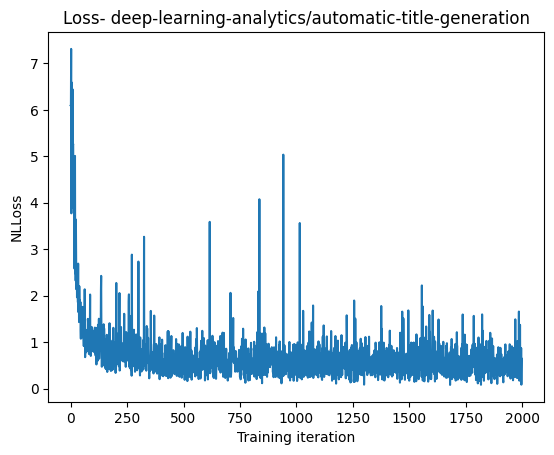

In [34]:
plt.figure()
plt.plot(losses)
plt.title("Loss- deep-learning-analytics/automatic-title-generation")
plt.xlabel("Training iteration")
plt.ylabel("NLLoss")
plt.show()

In [47]:
scores = []
for idx, [generated, rouge] in rouge_scores_val.items():
    scores.append(rouge)
    
moyenne = np.mean(scores)

study = val_df.copy()
new_cols = []
for i in range(len(study)):
    if i in rouge_scores_val:
        new_cols.append(rouge_scores_val[i])
    else:
        new_cols.append([np.nan, np.nan])

study[["generated_title", "rouge-l"]] = new_cols
study = study.dropna()

study['text_length'] = study['text'].apply(len)
study['titles_length'] = study['titles'].apply(len)
study['generated_title_length'] = study['generated_title'].apply(len)

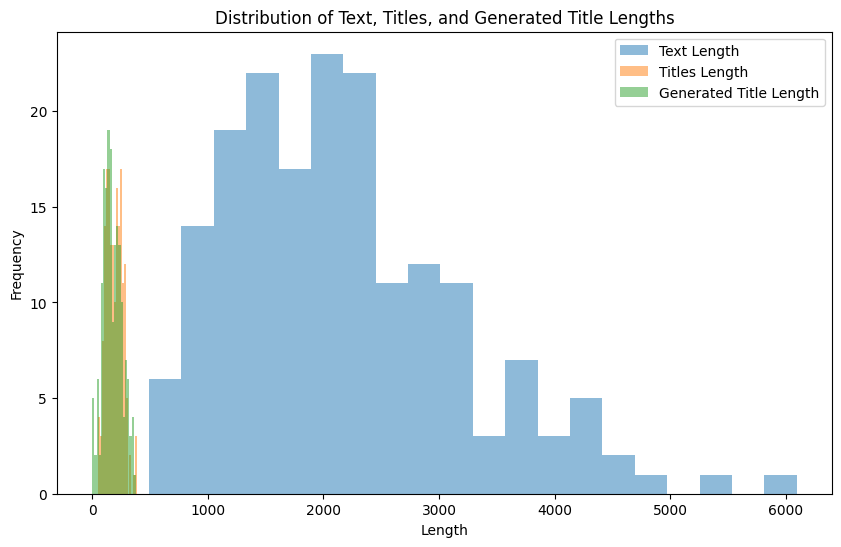

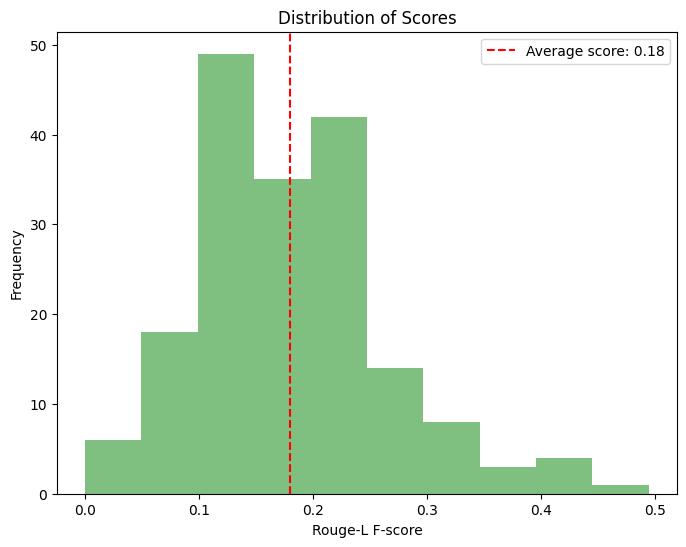

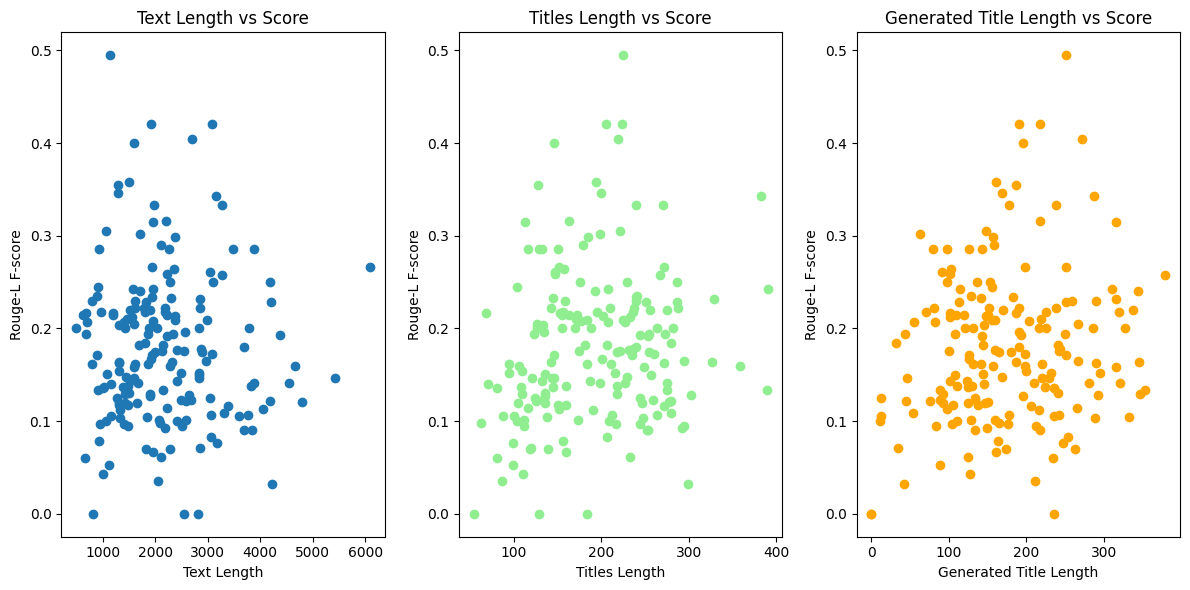

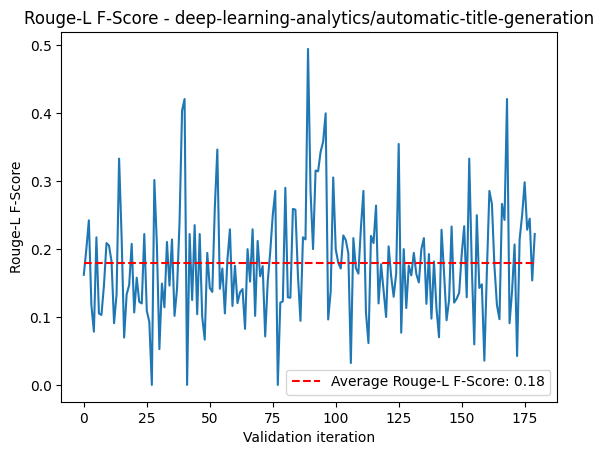

In [48]:
plt.figure(figsize=(10, 6))
plt.hist(study['text_length'], bins=20, alpha=0.5, label='Text Length')
plt.hist(study['titles_length'], bins=20, alpha=0.5, label='Titles Length')
plt.hist(study['generated_title_length'], bins=20, alpha=0.5, label='Generated Title Length')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text, Titles, and Generated Title Lengths')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(study['rouge-l'], bins=10, alpha=0.5, color='green')
plt.axvline(x=moyenne, color='r', linestyle='--', label=f"Average score: {np.round(moyenne, 3)}")
plt.xlabel('Rouge-L F-score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(study['text_length'], study['rouge-l'])
plt.xlabel('Text Length')
plt.ylabel('Rouge-L F-score')
plt.title('Text Length vs Score')

plt.subplot(1, 3, 2)
plt.scatter(study['titles_length'], study['rouge-l'], color="lightgreen")
plt.xlabel('Titles Length')
plt.ylabel('Rouge-L F-score')
plt.title('Titles Length vs Score')

plt.subplot(1, 3, 3)
plt.scatter(study['generated_title_length'], study['rouge-l'], color="orange")
plt.xlabel('Generated Title Length')
plt.ylabel('Rouge-L F-score')
plt.title('Generated Title Length vs Score')

plt.tight_layout()
plt.show()

plt.figure()
plt.plot(scores)
plt.hlines(np.mean(scores), xmin=0, xmax=len(scores)-1, colors='r', linestyles='dashed', label=f'Average Rouge-L F-Score: {round(np.mean(scores), 3)}')
plt.title("Rouge-L F-Score - deep-learning-analytics/automatic-title-generation")
plt.xlabel("Validation iteration")
plt.ylabel("Rouge-L F-Score")
plt.legend()
plt.show()

# **Create submission:**

In [25]:
test_df = pd.read_csv('/kaggle/input/data-title-generation/test_text.csv')
print(len(test_df))

model = best_model[0]
test_encodings = tokenizer(train_df['text'].tolist(), truncation=True, max_length=max_length, padding=True, return_tensors="pt")
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"])

1500


In [27]:
test_titles = []

with torch.no_grad():
    for i in tqdm(range(len(test_df)), total=len(test_df), desc="Test Iterations", leave=False):
        input_ids = test_dataset[i][0].unsqueeze(0).to(device)

        outputs = model.generate(input_ids, max_new_tokens=200, num_beams=4, num_return_sequences=1)
        predictions = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        test_titles.append(predictions)

test_df["titles"] = test_titles

test_df

,ID,text,titles
0,0,L'accès à leurs origines une fois la majorité ...,On ne peut pas annoncer le nom de Marine Le Pe...
1,1,"En 2017, François Bayrou s'était associé à Emm...","Le maire de l'Assemblée générale, Alain Juppé,..."
2,2,Ils ne passeront pas Noël ensemble. Le quotidi...,Les tribunaux de grande instance et leurs répe...
3,3,"Dans un message publié pour Noël, le fondateur...",Le budget de la Sécurité sociale: renforcer le...
4,4,Le suspense a duré jusqu'au bout. Le mardi 4 s...,On a procédé à une enquête sur la revendicatio...
...,...,...,...
1495,1495,Jean-Luc Guillotel n'était pas venu les mains ...,Les Français ne sont pas prêts à faire face à ...
1496,1496,"Des dizaines de véhicules utilitaires volés, d...",Aucune arme trouvée dans un train à Paris-Brie...
1497,1497,La totalité du produit de la vente ira à ce no...,"A l'occasion de cette audition, les familles d..."
1498,1498,Alors que l'épidémie gagne du terrain outre-At...,Ont participé à des manifestations organisées ...


In [34]:
test_df[['ID', 'titles']].to_csv("/kaggle/working/cos_sim_submission.csv", index=False)